In [1]:
# Based on ModuleEfficiencyScan.py

In [1]:
# External
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

# Internal
sys.path.append(os.path.abspath("../PyMacros"))
import Utils as ut

In [5]:
# # A gaussian approximation using a binomial probability
# def GetIneffUnc(q, n):
#   # n_failures = np.sum(data_["Failures"])
#   # n_total = np.sum(data_["Total"])
#   # q = n_failures / n_total # binomial
#   se_q = np.sqrt(q * (1 - q) / n)
#   return se_q

# Do you know any good at stats, or am I going to have to read a text book?
# Should I use poisson or binomial?

# Check this:
# Poisson distrubtion arises in the limit of a binomial when failures becomes small. 

def BinomialApproximation(data_):
    # What happens if the number of failures gets close to zero?
    n_failures = np.sum(data_["Failures"])
    n_total = np.sum(data_["Total"])
    q = n_failures / n_total # binomial
    se_q = np.sqrt(q * (1 - q) / n_total)
    return se_q

# # Supposed to be better for cases where the proportion is small
# # Doesn't fully rely on Gaussian approximation, whatever that means. 
# def wilson_score_interval(data_, alpha=0.05):
#     n_failures = np.sum(data_["Failures"])
#     n_total = np.sum(data_["Total"])
#     z = stats.norm.ppf(1 - alpha / 2)
#     phat = n_failures / n_total
#     denominator = 1 + z**2 / n_total
#     centre_adjusted_probability = phat + z**2 / (2 * n_total)
#     adjusted_standard_deviation = z * (phat * (1 - phat) + z**2 / (4 * n_total))**0.5 / n_total
#     lower_bound = (centre_adjusted_probability - adjusted_standard_deviation) / denominator
#     upper_bound = (centre_adjusted_probability + adjusted_standard_deviation) / denominator
#     return lower_bound, upper_bound

def PoissonUncertainty(data_):
    n_failures = np.sum(data_["Failures"])
    n_total = np.sum(data_["Total"])
    return np.sqrt(n_failures) / (n_total)

# This is nice
from statsmodels.stats.proportion import proportion_confint
def WilsonUncertainty(data_, conservative=True):
    # What happens if the number of failures gets close to zero?
    k = np.sum(data_["Failures"])
    N = np.sum(data_["Total"])
    lower, upper = proportion_confint(k, N, method="wilson")
    point = k/N
    if conservative: 
        return abs((upper - point) / 2)
    else:
        return abs((lower - point) / 2)

In [26]:
# Print results for a single data point
dataset = "MDC2020ae"
particle = "all"
PE = "10" 
layer = "3" 
cut = "track_crv1_only"

inDir=f"../Txt/{dataset}/concatenated/results"
finName = f"{inDir}/results_{particle}_{PE}PEs{layer}Layers_{cut}.csv"
    
data_ = pd.read_csv(finName) 

nsuccesses = np.sum(data_["Successes"])
nfailures = np.sum(data_["Failures"])
ntotal = np.sum(data_["Total"])

ineff = nfailures / ntotal 
ineffErr = WilsonUncertainty(data_, conservative=True)

# Append output string 
resultStr = f"""
particle: {particle}
PEs/layer: {PE}
Layers: {layer}/4
Cut: {cut}

Successes: {nsuccesses}
Failures: {nfailures}
Total: {ntotal}
Inefficiency: {nfailures}/{ntotal} = {ineff:.4f} +/- {ineffErr:.4f}%
"""

print(resultStr)

########################

inDir=f"../Txt/{dataset}/concatenated/failures_concise"
finName = f"{inDir}/failures_concise_{particle}_{PE}PEs{layer}Layers_{cut}.csv"

data_ = pd.read_csv(finName) 
print(data_)

inDir=f"../Txt/{dataset}/concatenated/failures_verbose"
finName = f"{inDir}/failures_verbose_{particle}_{PE}PEs{layer}Layers_{cut}.csv"

print(finName)

with open(finName, 'r') as file:
    # Iterate over each line in the file
    for i, line in enumerate(file):
        print(line.strip())
        if i > 39:
        # if i > 85:
            break
            



particle: all
PEs/layer: 10
Layers: 3/4
Cut: track_crv1_only

Successes: 619110
Failures: 28358
Total: 647468
Inefficiency: 28358/647468 = 0.0438 +/- 0.0003%

                   tag  evtinfo.run  evtinfo.subrun  evtinfo.event
0      001205_00000000         1205               0          97191
1      001205_00000000         1205             107          12670
2      001205_00000000         1205             107         168504
3      001205_00000000         1205             107         439956
4      001205_00000000         1205             107         444264
...                ...          ...             ...            ...
28353  001205_00000554         1205            9816         231906
28354  001205_00000554         1205            9913         471972
28355  001205_00000554         1205            9913         480845
28356  001205_00000554         1205            9914         193983
28357  001205_00000554         1205            9914         327709

[28358 rows x 4 columns]
../Txt/MDC

In [4]:
def PlotGraphOverlay(graphs_, title=None, xlabel=None, ylabel=None, xmin=0, xmax=-1, ymin=0, ymax=-1, labels_=[], fout="scatter.png", effLine=False, log=False, includeBlack=False, NDPI=300):
    
    # Create figure and axes
    fig, ax = plt.subplots()

    # Iterate over each pair of xy lists
    for i, (label, data_) in enumerate(graphs_.items()):

        colour = ut.colours[i+1]
        if includeBlack: colour = ut.colours[i]

        ax.errorbar(data_["x"], data_["y"], xerr=data_["xerr"], yerr=data_["yerr"], fmt='o', color=colour, markersize=4, ecolor=colour, capsize=2, elinewidth=1, linestyle='-',label=label)

    if log: 
        ax.set_yscale("log")

    # Set title, xlabel, and ylabel
    ax.set_title(title, fontsize=15, pad=10)
    ax.set_xlabel(xlabel, fontsize=13, labelpad=10)
    ax.set_ylabel(ylabel, fontsize=13, labelpad=10)

    # Set font size of tick labels on x and y axes
    ax.tick_params(axis='x', labelsize=13)  
    ax.tick_params(axis='y', labelsize=13)  

    if (ymax > ymin):
        ax.set_ylim(ymin, ymax)

    if (xmax > xmin):
        ax.set_xlim(xmin, xmax)
        
    # Add a line at 99.99% efficiency
    if effLine:
        ax.text(100, 1.2e-4, "99.99% efficiency", color="gray") #, transform=ax.transAxes, ha='right')
        ax.axhline(y=1e-4, color='gray', linestyle='--')

    ax.legend(loc="best", frameon=False, fontsize=13) # , markerscale=5)

    fig.tight_layout()
    fig.show()
    
    # Save the figure
    fig.savefig(fout, dpi=NDPI, bbox_inches="tight")
    print("---> Written", fout)

    # Clear memory
    # plt.close()
    # plt.clr()

    return

In [5]:
# Produce graph objects of inefficiency, failures, successes
def GetScan(PEs_, layer=3, particle="all", cut="no_track_cuts", dataset="MDC2020ae"):

    if False: print(f"---> Getting scan data for {layer}/4 layers, {particle}, {cut}, {dataset}.")
    
    inDir=f"../Txt/{dataset}/AugustCRVMeeting/FourthPass/concatenated/results"
    
    # # Template
    # gr_ = { "x" : list(PEs_)
    #        , "xerr" : [0] * len(PEs_)
    #        , "y" : [0] * len(PEs_)
    #        , "yerr" : [0] * len(PEs_)
    #       }
    
    ineff_ = { "x" : list(PEs_)
              , "xerr" : [0] * len(PEs_)
              , "y" : [0] * len(PEs_)
              , "yerr" : [0] * len(PEs_)
             }

    nfail_ = { "x" : list(PEs_)
                , "xerr" : [0] * len(PEs_)
                , "y" : [0] * len(PEs_)
                , "yerr" : [0] * len(PEs_)
             }
    nsucc_ = { "x" : list(PEs_)
                , "xerr" : [0] * len(PEs_)
                , "y" : [0] * len(PEs_)
                , "yerr" : [0] * len(PEs_)
             }

    for i, PE in enumerate(PEs_):

        finName = f"{inDir}/results_{particle}_{PE}PEs{layer}Layers_{cut}.csv"
    
        data_ = pd.read_csv(finName) 
        
        ineff_["y"][i] = np.sum(data_["Failures"])/np.sum(data_["Total"])
        ineff_["yerr"][i] = WilsonUncertainty(data_, conservative=True)
        
        nfail_["y"][i] = np.sum(data_["Failures"])
        nfail_["yerr"][i] = np.sqrt(np.sum(data_["Failures"])) # sqrt(N)

        nsucc_["y"][i] = np.sum(data_["Successes"])
        nsucc_["yerr"][i] = np.sqrt(np.sum(data_["Successes"])) # sqrt(N)

    if False: print("Done!")

    # print(len(nsucc_["x"]), len(nsucc_["y"]))
    
    return {"ineff" : ineff_, "nfail" : nfail_, "nsucc" : nsucc_}

In [6]:
# Setup parameters
partial = False
dataset = "MDC2020ae"
PEs_ = np.arange(10, 135, 5)
if partial:
    PEs_ = np.arange(10, 125, 5)
outDir=f"../Images/{dataset}/ThresholdScan/TrackCutsFourthPass/"

---> Written ../Images/MDC2020ae/ThresholdScan/TrackCutsFourthPass//gr_ineff_log_layer_overlay_no_track_cuts_all.png
---> Written ../Images/MDC2020ae/ThresholdScan/TrackCutsFourthPass//gr_ineff_log_layer_overlay_track_cuts_all.png


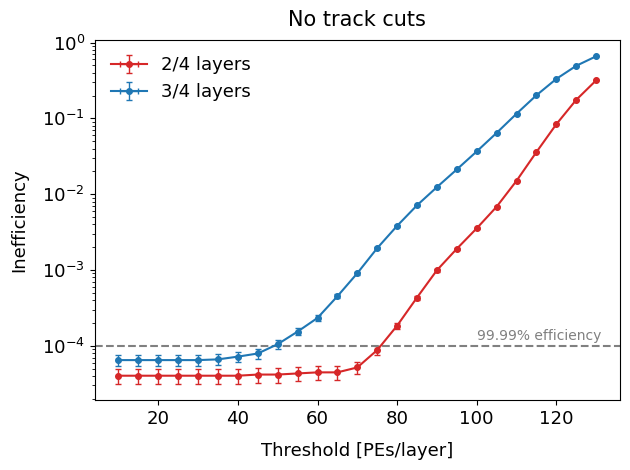

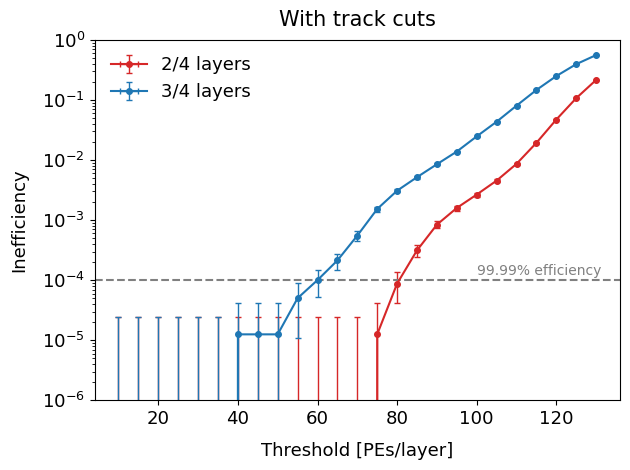

In [7]:
# Compare inefficiency between layers (good sanity check)
particle = "all"
cut = "no_track_cuts"

PlotGraphOverlay( {"2/4 layers" : GetScan(PEs_, 2, "all", cut)["ineff"], 
                   "3/4 layers" : GetScan(PEs_, 3, "all", cut)["ineff"] }
                 , title="No track cuts", xlabel="Threshold [PEs/layer]", ylabel=f"Inefficiency", fout=f"{outDir}/gr_ineff_log_layer_overlay_{cut}_{particle}.png"
                 , log=True, effLine=True)

particle = "all"
cut = "track_cuts"

PlotGraphOverlay( {"2/4 layers" : GetScan(PEs_, 2, "all", cut)["ineff"], 
                   "3/4 layers" : GetScan(PEs_, 3, "all", cut)["ineff"] }
                 , ymin=1e-6, ymax=1e0
                 , title="With track cuts", xlabel="Threshold [PEs/layer]", ylabel=f"Inefficiency", fout=f"{outDir}/gr_ineff_log_layer_overlay_{cut}_{particle}.png"
                 , log=True, effLine=True)

# PlotGraphOverlay( {"2/4 layers" : GetScan(PEs_, 2, "all", cut)["ineff"], 
#                    "3/4 layers" : GetScan(PEs_, 3, "all", cut)["ineff"] }
#                  , ymin=1e-6, ymax=1e0
#                  , title="With track cuts", xlabel="Threshold [PEs/layer]", ylabel=f"Inefficiency", fout=f"{outDir}/gr_ineff_log_layer_overlay_{cut}_{particle}.png"
#                  , log=False, effLine=True)

---> Written ../Images/MDC2020ae/ThresholdScan/TrackCutsFourthPass//gr_ineff_log_cut_overlay_3layers_all.png


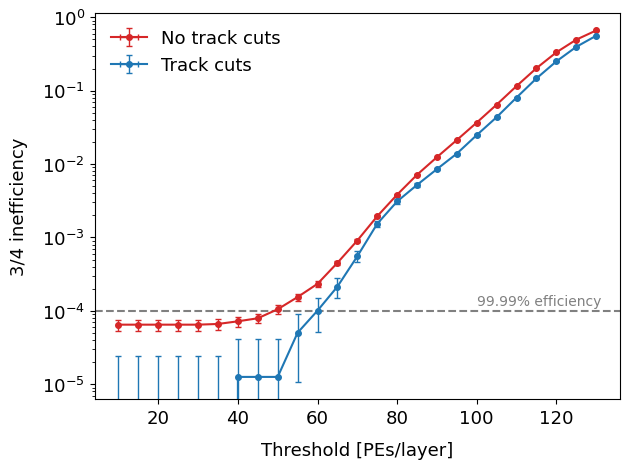

In [8]:
# Compare inefficiency between cuts 
particle = "all"
layer = "2"

# PlotGraphOverlay( {"No track cuts" : GetScan(PEs_, layer, "all", "singles")["ineff"], 
#                    "Track cuts" : GetScan(PEs_, layer, "all", "singles_track_cuts")["ineff"] }
#                  , xmax=135, xlabel="Threshold [PEs/layer]", ylabel=f"{layer}/4 inefficiency", fout=f"{outDir}/gr_ineff_log_layer_overlay_{cut}_{particle}.png", log=True)

layer = "3"

PlotGraphOverlay( {"No track cuts" : GetScan(PEs_, layer, "all", "no_track_cuts")["ineff"], 
                   "Track cuts" : GetScan(PEs_, layer, "all", "track_cuts")["ineff"] }
                 # , ymin=1e-6, ymax=1e0
                 , xlabel="Threshold [PEs/layer]", ylabel=f"{layer}/4 inefficiency", fout=f"{outDir}/gr_ineff_log_cut_overlay_{layer}layers_{particle}.png"
                 , log=True, effLine=True) 

---> Written ../Images/MDC2020ae/ThresholdScan/TrackCutsFourthPass//gr_log_data_sim_partial_overlay_no_track_cuts.png
---> Written ../Images/MDC2020ae/ThresholdScan/TrackCutsFourthPass//gr_log_data_sim_partial_overlay_track_cuts.png


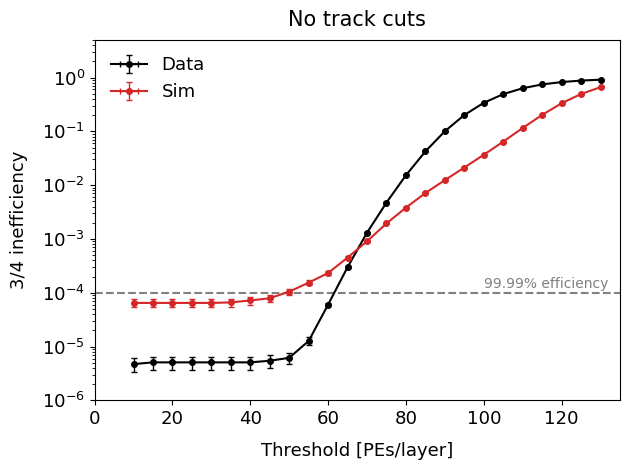

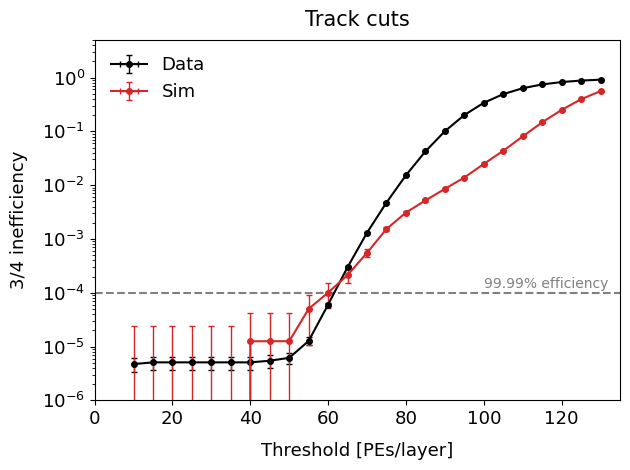

In [9]:
# Compare with Tyler's results
# Tyler's data
finNameWB = f"../Txt/Wideband/Tyler2024.csv"
dataWB = pd.read_csv(finNameWB)
partial = False
if partial:
    dataWB = dataWB[:16]
wb_thresholds = dataWB["Thresholds"]
wb_ineff = dataWB["Observed 3/4 inefficiency"]
wb_ineff_err = dataWB["Error bars, observed 3/4 inefficiency"]

cut="no_track_cuts"

PlotGraphOverlay( {"Data" : {"x": wb_thresholds, "xerr" : [0]*len(wb_thresholds), "y" : wb_ineff, "yerr" : wb_ineff_err}
                   ,"Sim" : GetScan(PEs_, 3, "all", cut)["ineff"] }
                 , title="No track cuts", xlabel="Threshold [PEs/layer]", ylabel=f"3/4 inefficiency", fout=f"{outDir}/gr_log_data_sim_partial_overlay_{cut}.png"
                 , ymin=1e-6, ymax=5e0, xmax=135, log=True, includeBlack=True, effLine=True)

# PlotGraphOverlay( {"Data" : {"x": wb_thresholds, "xerr" : [0]*len(wb_thresholds), "y" : wb_ineff, "yerr" : wb_ineff_err}
#                    ,"Sim (all)" : GetScan(PEs_, 3, "all", cut)["ineff"] 
#                    ,"Sim (muons)" : GetScan(PEs_, 3, "muons", cut)["ineff"] 
#                    ,"Sim (non-muons)" : GetScan(PEs_, 3, "non_muons", cut)["ineff"] 
#                   }
#                  , title="No track cuts", xlabel="Threshold [PEs/layer]", ylabel=f"3/4 inefficiency", fout=f"{outDir}/gr_log_data_sim_overlay_{cut}.png"
#                  , ymin=1e-6, ymax=5e0, xmax=135, log=True, includeBlack=True, effLine=True)

cut="track_cuts"

PlotGraphOverlay( {"Data" : {"x": wb_thresholds, "xerr" : [0]*len(wb_thresholds), "y" : wb_ineff, "yerr" : wb_ineff_err}
                   ,"Sim" : GetScan(PEs_, 3, "all", cut)["ineff"] }
                 , title="Track cuts", xlabel="Threshold [PEs/layer]", ylabel=f"3/4 inefficiency", fout=f"{outDir}/gr_log_data_sim_partial_overlay_{cut}.png"
                 , ymin=1e-6, ymax=5e0, xmax=135, log=True, includeBlack=True, effLine=True)

# PlotGraphOverlay( {"Data" : {"x": wb_thresholds, "xerr" : [0]*len(wb_thresholds), "y" : wb_ineff, "yerr" : wb_ineff_err}
#                    ,"Sim" : GetScan(PEs_, 3, "all", cut)["ineff"] }
#                  , title="Track cuts", xlabel="Threshold [PEs/layer]", ylabel=f"3/4 inefficiency", fout=f"{outDir}/gr_log_data_sim_partial_overlay_{cut}.png"
#                  , ymin=0, ymax=1e-4, xmax=135, log=False, includeBlack=True, effLine=True)

# PlotGraphOverlay( {"Data" : {"x": wb_thresholds, "xerr" : [0]*len(wb_thresholds), "y" : wb_ineff, "yerr" : wb_ineff_err}
#                    ,"Sim (all)" : GetScan(PEs_, 3, "all", cut)["ineff"] 
#                    ,"Sim (muons)" : GetScan(PEs_, 3, "muons", cut)["ineff"] 
#                    ,"Sim (non-muons)" : GetScan(PEs_, 3, "non_muons", cut)["ineff"] 
#                   }
#                  , title="Track cuts", xlabel="Threshold [PEs/layer]", ylabel=f"3/4 inefficiency", fout=f"{outDir}/gr_log_data_sim_overlay_{cut}.png"
#                  , ymin=1e-6, ymax=5e0, xmax=135, log=True, includeBlack=True, effLine=True)



---> Written ../Images/MDC2020ae/ThresholdScan/TrackCutsFourthPass//gr_nfail_particle_overlay_no_track_cuts.png
---> Written ../Images/MDC2020ae/ThresholdScan/TrackCutsFourthPass//gr_nfail_particle_overlay_track_cuts.png


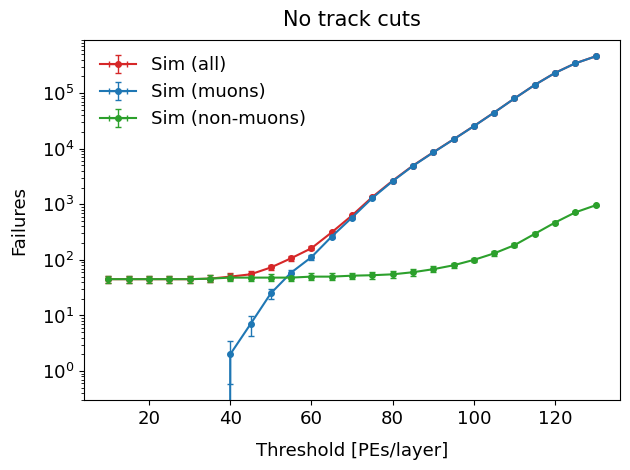

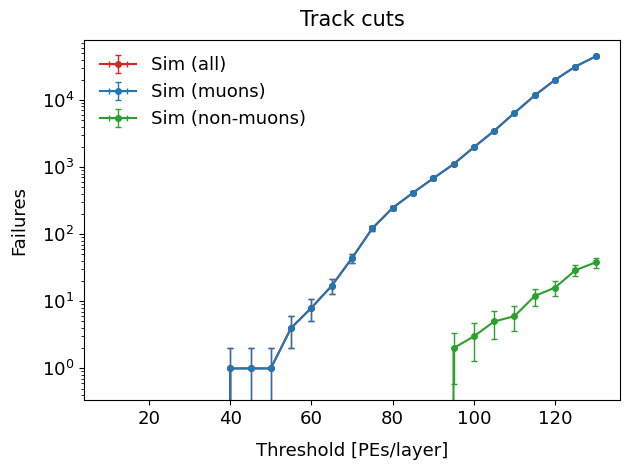

In [19]:
# Compare failures 
particles_ = ["all", "muons", "non_muons"]
layer = "3"

# for cut in {no_track_cuts", "track_cuts"]:
cut="no_track_cuts"
PlotGraphOverlay( {"Sim (all)" : GetScan(PEs_, 3, "all", cut)["nfail"] 
                   ,"Sim (muons)" : GetScan(PEs_, 3, "muons", cut)["nfail"] 
                   ,"Sim (non-muons)" : GetScan(PEs_, 3, "non_muons", cut)["nfail"] 
                  }
                 , title="No track cuts"
                 , xlabel="Threshold [PEs/layer]"
                 , ylabel="Failures"
                 , fout=f"{outDir}/gr_nfail_particle_overlay_{cut}.png"
                 , log=True
                 )
cut="track_cuts"
PlotGraphOverlay( {"Sim (all)" : GetScan(PEs_, 3, "all", cut)["nfail"] 
                   ,"Sim (muons)" : GetScan(PEs_, 3, "muons", cut)["nfail"] 
                   ,"Sim (non-muons)" : GetScan(PEs_, 3, "non_muons", cut)["nfail"] 
                  }
                 , title="Track cuts"
                 , xlabel="Threshold [PEs/layer]"
                 , ylabel="Failures"
                 , fout=f"{outDir}/gr_nfail_particle_overlay_{cut}.png"
                 , log=True
                 )
# for particle in particles_:
#     PlotGraphOverlay( {"No track cuts" : GetScan(PEs_, layer, particle, "no_track_cuts")["nfail"], 
#                        "Track cuts" : GetScan(PEs_, layer, particle, "track_cuts")["nfail"] }
#                      , xmax=135, title=particle, xlabel="Threshold [PEs/layer]", ylabel=f"Failures", fout=f"{outDir}/gr_nfail_cut_overlay_{layer}layers_{particle}.png", log=False)
#     PlotGraphOverlay( {"No track cuts" : GetScan(PEs_, layer, particle, "no_track_cuts")["nfail"], 
#                        "Track cuts" : GetScan(PEs_, layer, particle, "track_cuts")["nfail"] }
#                      , xmax=135, title=particle, xlabel="Threshold [PEs/layer]", ylabel=f"Failures", fout=f"{outDir}/gr_log_nfail_cut_overlay_{layer}layers_{particle}.png", log=True)

In [11]:
# # Compare successes 
# particle = "all"
# layer = "3"

# # PlotGraphOverlay( {"No track cuts" : GetScan(PEs_, layer, "all", "singles")["nsucc"], 
# #                    "Track cuts" : GetScan(PEs_, layer, "all", "singles_track_cuts")["nsucc"] }
# #                  , xmax=135, xlabel="Threshold [PEs/layer]", ylabel=f"Successes", fout=f"{outDir}/gr_nsucc_log_cut_overlay_{layer}layers_{particle}.png", log=True)

# PlotGraphOverlay( {"No track cuts" : GetScan(PEs_, layer, "all", "no_track_cuts")["nsucc"], 
#                    "Track cuts" : GetScan(PEs_, layer, "all", "track_cuts")["nsucc"] }
#                  , xmax=135, xlabel="Threshold [PEs/layer]", ylabel=f"Successes", fout=f"{outDir}/gr_nsucc_cut_overlay_{layer}layers_{particle}.png", log=False)

In [12]:
# # Compare successes 
# particles_ = ["all", "muons", "non_muons"]
# layer = "3"

# for particle in particles_:
#     PlotGraphOverlay( {"No track cuts" : GetScan(PEs_, layer, particle, "no_track_cuts")["nsucc"], 
#                        "Track cuts" : GetScan(PEs_, layer, particle, "track_cuts")["nsucc"] }
#                      , xmax=135, title=particle, xlabel="Threshold [PEs/layer]", ylabel=f"Successes", fout=f"{outDir}/gr_nsucc_cut_overlay_{layer}layers_{particle}.png", log=False)
#     PlotGraphOverlay( {"No track cuts" : GetScan(PEs_, layer, particle, "no_track_cuts")["nsucc"], 
#                        "Track cuts" : GetScan(PEs_, layer, particle, "track_cuts")["nsucc"] }
#                      , xmax=135, title=particle, xlabel="Threshold [PEs/layer]", ylabel=f"Successes", fout=f"{outDir}/gr_log_nsucc_cut_overlay_{layer}layers_{particle}.png", log=True)

In [13]:
# from matplotlib.ticker import ScalarFormatter

# def PlotGraphRatio(graphs_, title=None, xlabel=None, ylabel=None, xmin=0, xmax=-1, ymin=0, ymax=-1, fout="ratio.png", log=False, NDPI=300, limitRatio=False, ratioMin=0, ratioMax=1):
    
#     if len(graphs_) != 2: 
#         raise Exception("!!! PlotGraphRatio must take exactly two graphs as input !!!")
    
#     # Create figure and axes
#     fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(8, 6))

#     # Extract the first and second graph
#     graph1, graph2 = graphs_.values()

#     # Iterate over each pair of xy lists
#     for i, (label, graph_) in enumerate(graphs_.items()):

#         colour = ut.colours[i+1]

#         ax1.errorbar(graph_["x"], graph_["y"], xerr=graph_["xerr"], yerr=graph_["yerr"], fmt='o', color=colour, markersize=4, ecolor=colour, capsize=2, elinewidth=1, linestyle='-',label=label)

#     # # Plot the first graph in the top frame
#     # ax1.errorbar(graph1["x"], graph1["y"], xerr=graph1["xerr"], yerr=graph1["yerr"], fmt='o', color=ut.colours[1], markersize=4, ecolor=ut.colours[1], capsize=2, elinewidth=1, linestyle='-', label='Graph 1')

#     # # Plot the second graph in the top frame
#     # ax1.errorbar(graph2["x"], graph2["y"], xerr=graph2["xerr"], yerr=graph2["yerr"], fmt='o', color=ut.colours[2], markersize=4, ecolor=ut.colours[2], capsize=2, elinewidth=1, linestyle='-', label='Graph 2')

#     if log: 
#         ax1.set_yscale("log")

#     # Remove markers for main x-axis
#     ax1.set_xticks([])

#     # Calculate the ratio of the y-values with a check for division by zero
#     ratio = np.divide(graph1["y"], graph2["y"], out=np.full_like(graph1["y"], np.nan, dtype=float), where=(graph2["y"] != 0))

#     # Calculate the statistical uncertainty for the ratio
#     # THIS IGNORES THE CORRELATION SO IS AN OVERESTIMATION.
#     ratio_err = np.divide(np.sqrt(graph1["y"]), graph2["y"], out=np.full_like(graph1["y"], np.nan, dtype=float), where=(graph2["y"] != 0))

#     # Plot the ratio in the lower frame with error bars
#     ax2.errorbar(graph1["x"], ratio, yerr=ratio_err, fmt='o', color='black', markersize=4, capsize=2, elinewidth=1, linestyle='-')

#     # Add a horizontal line at ratio = 1
#     # ax2.axhline(y=1.0, color='gray', linestyle='--', linewidth=1)

#     # Set the limits for the ratio plot if specified
#     if limitRatio:
#         ax2.set_ylim(ratioMin, ratioMax)

#     # Set the x-axis limits for both plots
#     if (xmax > xmin):
#         ax1.set_xlim(xmin, xmax)
#         ax2.set_xlim(xmin, xmax)

#     # Set title, xlabel, and ylabel
#     ax1.set_title(title, fontsize=16, pad=10)
#     ax1.set_ylabel(ylabel, fontsize=14, labelpad=10)
#     ax2.set_xlabel(xlabel, fontsize=14, labelpad=10)
#     ax2.set_ylabel("Ratio", fontsize=14, labelpad=10)

#     # Set font size of tick labels on x and y axes
#     ax1.tick_params(axis='y', labelsize=14)  
#     ax2.tick_params(axis='x', labelsize=14)
#     ax2.tick_params(axis='y', labelsize=14)

#     # Scientific notation for axes if necessary
#     if ax2.get_xlim()[1] > 9999:
#         ax2.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
#         ax2.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
#         ax2.xaxis.offsetText.set_fontsize(14)
#     if ax1.get_ylim()[1] > 9999:
#         ax1.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
#         ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
#         ax1.yaxis.offsetText.set_fontsize(14)

#     # Add legend to the top frame
#     ax1.legend(loc="best", frameon=False, fontsize=14)

#     # Adjust the spacing between subplots
#     fig.tight_layout()
#     fig.subplots_adjust(hspace=-0.01)

#     # Show plot
#     fig.show()

#     # Save the figure
#     fig.savefig(fout, dpi=NDPI, bbox_inches="tight")
#     print("---> Written", fout)

#     # Clear memory
#     # plt.close()

#     return

In [14]:
# PlotGraphRatio( {"No track cuts" : GetScan(PEs_, layer, "all", "no_track_cuts")["nfail"], 
#                    "Track cuts" : GetScan(PEs_, layer, "all", "track_cuts")["nfail"] }
#                  , xmax=135, xlabel="Threshold [PEs/layer]", ylabel=f"Failures", fout=f"{outDir}/gr_nfail_cut_ratio_{layer}layers_{particle}.png", log=True)

In [15]:
# PlotGraphRatio( {"No track cuts" : GetScan(PEs_, layer, "all", "no_track_cuts")["nsucc"], 
#                    "Track cuts" : GetScan(PEs_, layer, "all", "track_cuts")["nsucc"] }
#                  , xmax=135, xlabel="Threshold [PEs/layer]", ylabel=f"Successes", fout=f"{outDir}/gr_nsucc_cut_ratio_{layer}layers_{particle}.png", log=True)

In [16]:
# # Muons
# particle="muons"
# PlotGraphRatio( {"No track cuts" : GetScan(PEs_, layer, particle, "no_track_cuts")["nfail"], 
#                    "Track cuts" : GetScan(PEs_, layer, particle, "track_cuts")["nfail"] }
#                  , xmax=135, title="Muons", xlabel="Threshold [PEs/layer]", ylabel=f"Failures", fout=f"{outDir}/gr_nfail_cut_ratio_{layer}layers_{particle}.png", log=False)
# # Muons
# # particle="muons"
# PlotGraphRatio( {"No track cuts" : GetScan(PEs_, layer, particle, "no_track_cuts")["nsucc"], 
#                    "Track cuts" : GetScan(PEs_, layer, particle, "track_cuts")["nsucc"] }
#                  , xmax=135, title="Muons", xlabel="Threshold [PEs/layer]", ylabel=f"Successes", fout=f"{outDir}/gr_nsucc_cut_ratio_{layer}layers_{particle}.png", log=False)

In [17]:
# # Non muons
# particle="non_muons"
# PlotGraphRatio( {"No track cuts" : GetScan(PEs_, layer, particle, "no_track_cuts")["nfail"], 
#                    "Track cuts" : GetScan(PEs_, layer, particle, "track_cuts")["nfail"] }
#                  , xmax=135, title="Non-muons", xlabel="Threshold [PEs/layer]", ylabel=f"Failures", fout=f"{outDir}/gr_nfail_cut_ratio_{layer}layers_{particle}.png", log=False)
# # Muons
# # particle="muons"
# PlotGraphRatio( {"No track cuts" : GetScan(PEs_, layer, particle, "no_track_cuts")["nsucc"], 
#                    "Track cuts" : GetScan(PEs_, layer, particle, "track_cuts")["nsucc"] }
#                  , xmax=135, title="Non-muons", xlabel="Threshold [PEs/layer]", ylabel=f"Successes", fout=f"{outDir}/gr_nsucc_cut_ratio_{layer}layers_{particle}.png", log=False)